#GAN Based data augmentation - Stage 1
In this implementation the GAN network itself is functional and is able to reproduce 1 image.
For more images more hyperparameter testing/tuning and changes in the network infrastructure are neccesarry.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

import os
os.chdir('/content/gdrive/My Drive/Deep_learning/final_project')

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision
from functools import reduce
from torch.utils.data.sampler import SubsetRandomSampler
from operator import add
import pandas as pd
from skimage.io import imread
from skimage.transform import resize

!pip install elasticdeform
import imageio, elasticdeform
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset

import torch
from torch.utils.data import DataLoader
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
%matplotlib nbagg
%matplotlib inline
plt.style.use(["seaborn-deep", "seaborn-whitegrid"])
import os

In [3]:
grade = pd.read_csv('warwick_data/Grade.csv')
print(grade.columns)
print(grade.sample(5))
benign = list(grade.loc[grade[' grade (GlaS)'].str.contains('benign')].name)
malignant = list(grade.loc[grade[' grade (GlaS)'].str.contains('malignant')].name)


Index(['name', 'patient ID', ' grade (GlaS)',
       ' grade (Sirinukunwattana et al. 2015)'],
      dtype='object')
         name  patient ID  grade (GlaS)  grade (Sirinukunwattana et al. 2015)
131  train_56           4        benign                           adenomatous
7    testA_16           4     malignant             moderately differentiated
119  train_45          10        benign                               healthy
136  train_60           6     malignant             moderately differentiated
11    testA_2           3        benign                               healthy


In [0]:

masks = []
labels = []
image_size=64
read_size=64
def get_label(file):
    if file[:-4] in benign:
      return 0
    elif file[:-4] in malignant:
      return 1
    else:
      return 99
counter = 0
size=(read_size,read_size) # original size is 576x576 -> maybe increas it for later tests
for root, dirs, files in os.walk('warwick_data/'):
   for f in files:
      if not f.endswith('anno.bmp') and not f.endswith('csv'):

        mask_path = f[:-4]+'_anno.bmp'
        masks.append(resize(imread(os.path.join(root, mask_path)), size, mode='constant',anti_aliasing=True)>0)
        labels.append(get_label(f))
        counter+=1
        if counter==2:
          break


In [0]:
def to_numpy(masks):
    Y = np.array(masks, np.float32)
    print('Loaded %d masks' % len(Y))
    return Y

In [6]:
Y = to_numpy(masks)

Loaded 2 masks


In [0]:
ix = np.random.choice(len(Y), len(Y), False)
#print(ix)
tr, val = np.split(ix, [int(len(Y)/4*3)]) # set better values
tr,val = [0],[0]

In [0]:

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]
        return x, y

    def __len__(self):
        return self.tensors[0].size(0)



# Dataloader

In [0]:

batch_size = 1
labels = np.asarray(labels, dtype=np.int64)
train = torch.utils.data.TensorDataset(torch.from_numpy(Y[tr, np.newaxis]), torch.from_numpy(labels[tr]))
test =  torch.utils.data.TensorDataset(torch.from_numpy(Y[val, np.newaxis]), torch.from_numpy(labels[val]))
'''
train = CustomTensorDataset(tensors=(torch.from_numpy(X[tr, np.newaxis]), torch.from_numpy(labels[tr]).unsqueeze(1)),transform= transforms.Compose([transforms.ToPILImage(),
                                                                                                                                                    transforms.RandomCrop(image_size),
                                                                                                                                                    transforms.ToTensor()
                                                                                                                                                    ]))
#test =  CustomTensorDataset(tensors=(torch.from_numpy(X[val, np.newaxis]), torch.from_numpy(labels[val]).unsqueeze(1)),transform= transforms.Compose([transforms.ToPILImage(),
                                                                                                                                                      transforms.RandomCrop(image_size),
                                                                                                                                                      transforms.ToTensor()
                                                                                                                                                      ]))
'''
#train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
data_tr = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
data_val = DataLoader(test, batch_size=batch_size, shuffle=False, pin_memory=cuda)

#test_loader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), batch_size=batch_size, shuffle=False)


torch.Size([3, 64, 64])


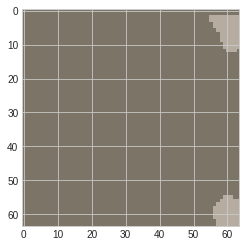

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs= next(iter(data_tr))[0]
#print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)
imshow(out)

#Network

In [11]:
from torch import nn
PATH='GAN/models/model_10'

latent_dim = 100
ndf = 64 # number of features in discriminator
ngf = 64 # number of featuers in generator
lr_gen =  3e-4
lr_dis =  4e-4

load_model=False

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
class Squece(nn.Module):
    def forward(self, x):
        return x.view(-1, latent_dim, 1, 1)
# The generator takes random `latent` noise and
# turns it into an MNIST image.

generator = nn.Sequential(
    # nn.ConvTranspose2d can be seen as the inverse operation
    # of Conv2d, where after convolution we arrive at an
    # upscaled image.
    nn.Linear(latent_dim,latent_dim),
    nn.ReLU(),
    Squece(),
    #nn.ConvTranspose2d(latent_dim, ngf*16, kernel_size=3, stride=2),
    #nn.BatchNorm2d(ngf*16),
    #nn.ReLU(),
    nn.utils.spectral_norm(nn.ConvTranspose2d(latent_dim, ngf*8, kernel_size=3, stride=2)),
    nn.BatchNorm2d(ngf*8),
    nn.ReLU(),
    nn.utils.spectral_norm(nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=3, stride=2)),
    nn.BatchNorm2d(ngf*4),
    nn.ReLU(),
    nn.utils.spectral_norm(nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=3, stride=2)),
    nn.BatchNorm2d(ngf*2),
    nn.ReLU(),
    nn.ConvTranspose2d(ngf*2, ngf, kernel_size=3, stride=2),
    nn.BatchNorm2d(ngf),
    nn.ReLU(),
    nn.ConvTranspose2d(ngf, 1, kernel_size=4, stride=2),
    nn.Sigmoid() # Image intensities are in [0, 1]
).to(device)

# The discriminator takes an image (real or fake)
# and decides whether it is generated or not.
discriminator = nn.Sequential(
    nn.utils.spectral_norm(nn.Conv2d(1, ndf, kernel_size=4, stride=2)),
    nn.LeakyReLU(0.2),
    #nn.utils.spectral_norm(nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2)),
    nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2),

    nn.BatchNorm2d(ndf*2),
    nn.LeakyReLU(0.2),
    #nn.utils.spectral_norm(nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2)),
    nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2),
    
    nn.BatchNorm2d(ndf*4),
    nn.LeakyReLU(0.2),
    nn.utils.spectral_norm(nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2)),
    nn.BatchNorm2d(ndf*8),
    nn.LeakyReLU(0.2),
    Flatten(),
    nn.Linear(ndf*8*4, 1),
    #nn.Linear(ndf*4*196, 1),

    nn.Sigmoid()
).to(device)



loss = nn.BCELoss()
print("Using device:", device)

generator_optim = torch.optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=lr_dis, betas=(0.5, 0.999))

if load_model:
    checkpoint = torch.load(PATH)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    generator_optim.load_state_dict(checkpoint['generator_optim_state_dict'])
    discriminator_optim.load_state_dict(checkpoint['discriminator_optim_state_dict'])
    loss.load_state_dict('loss')

print('generator')
print(generator)
print('discriminator')
print(discriminator)


Using device: cuda:0
generator
Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
  (2): Squece()
  (3): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(2, 2))
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
  (16): Sigmoid()
)
discriminator
Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
  (1): LeakyReLU

#Training

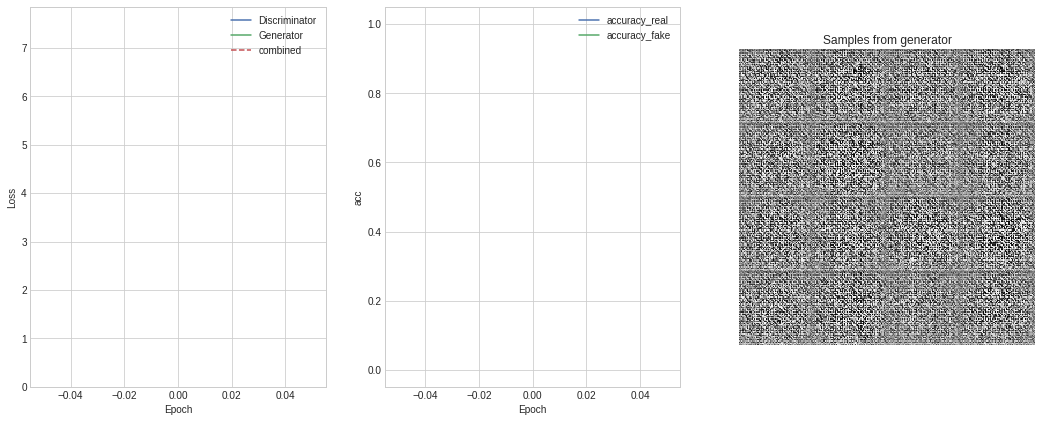

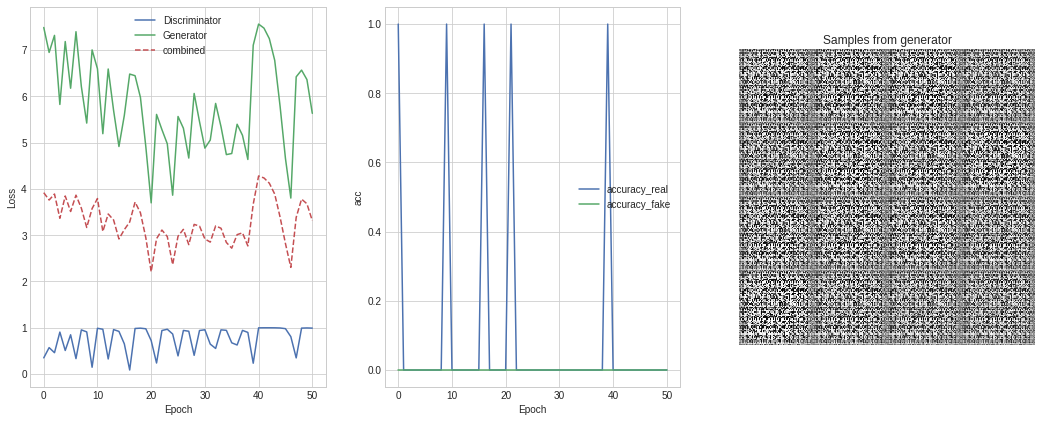

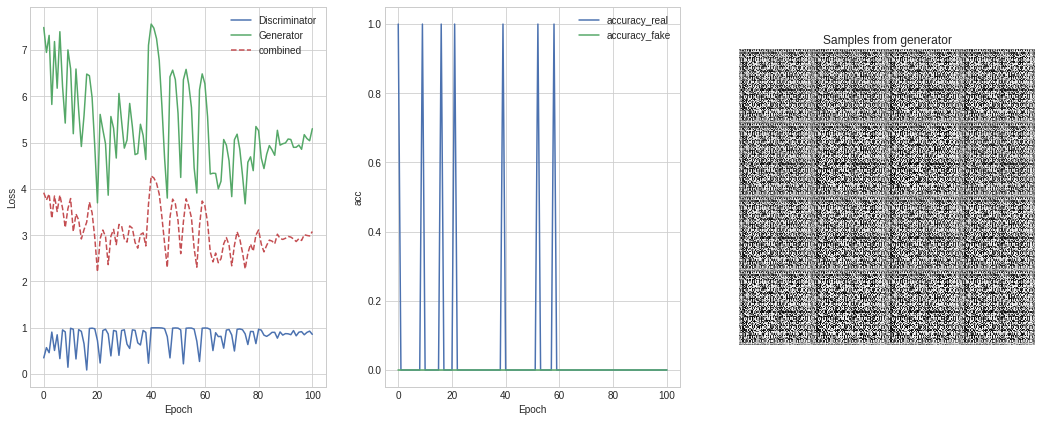

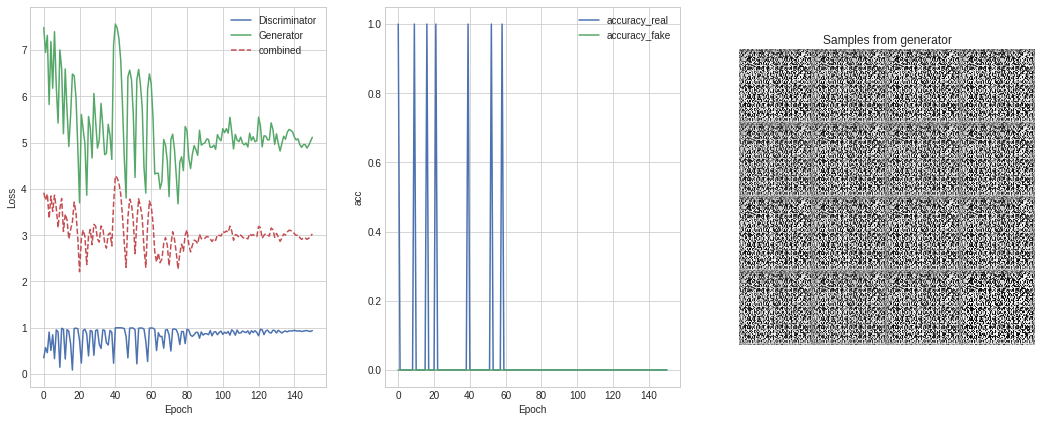

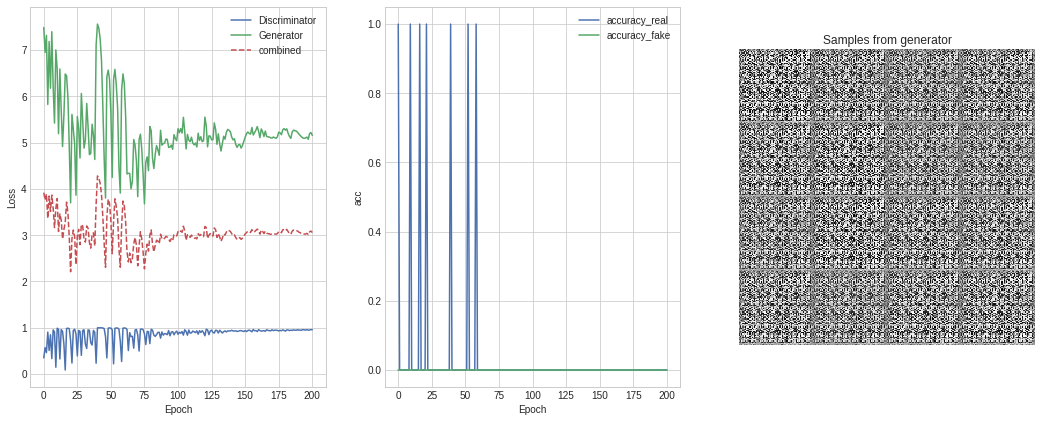

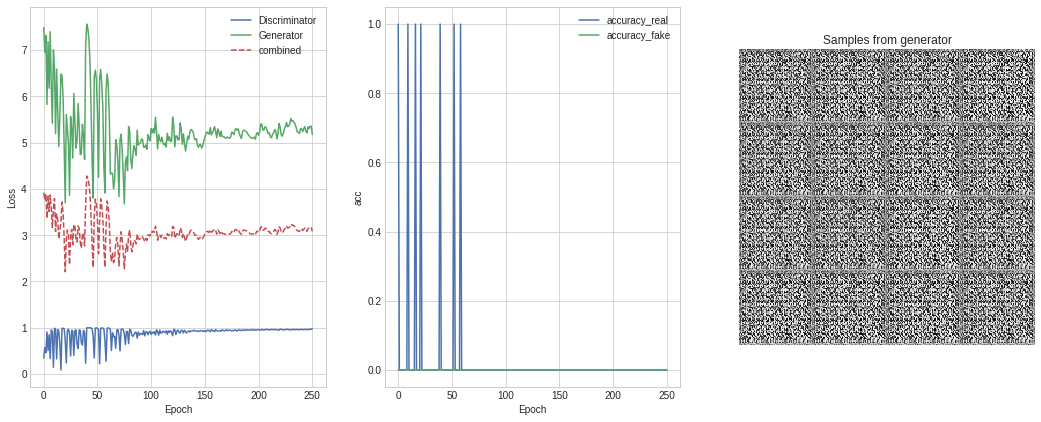

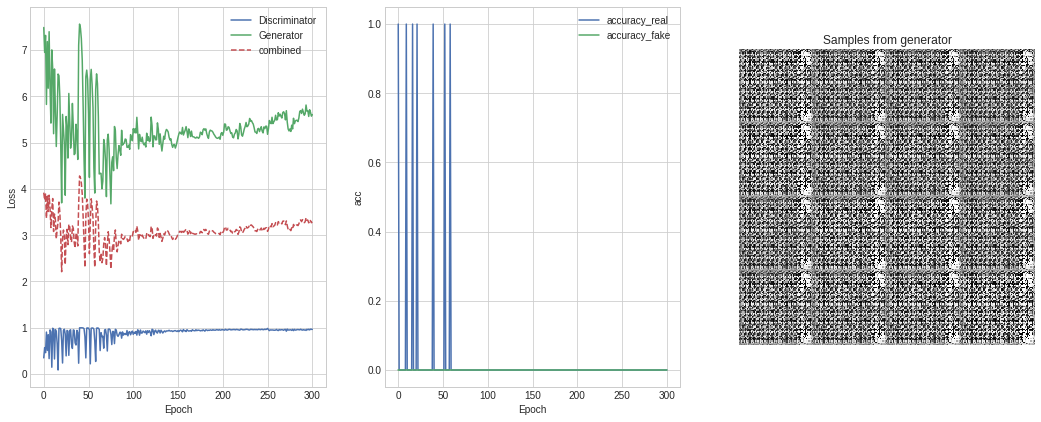

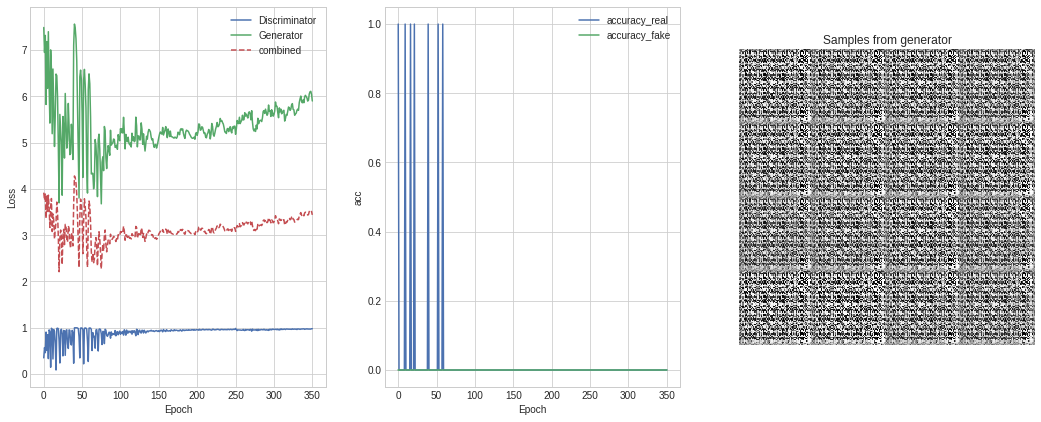

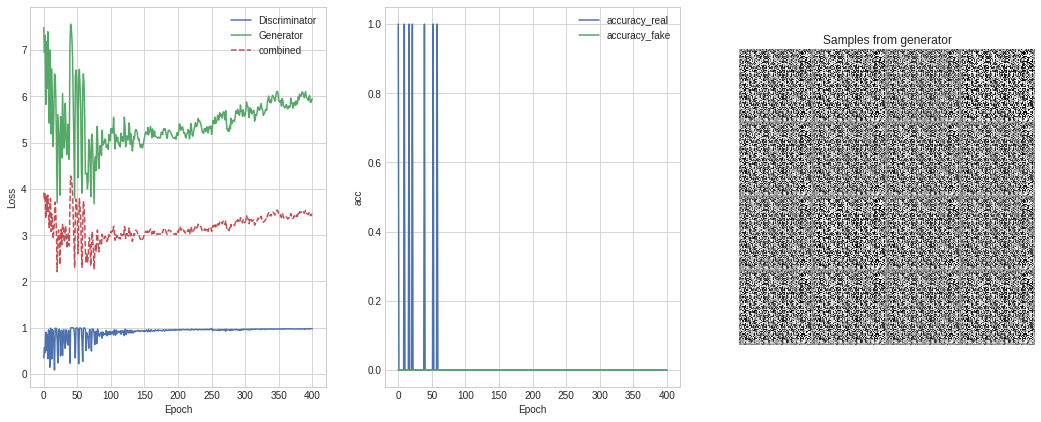

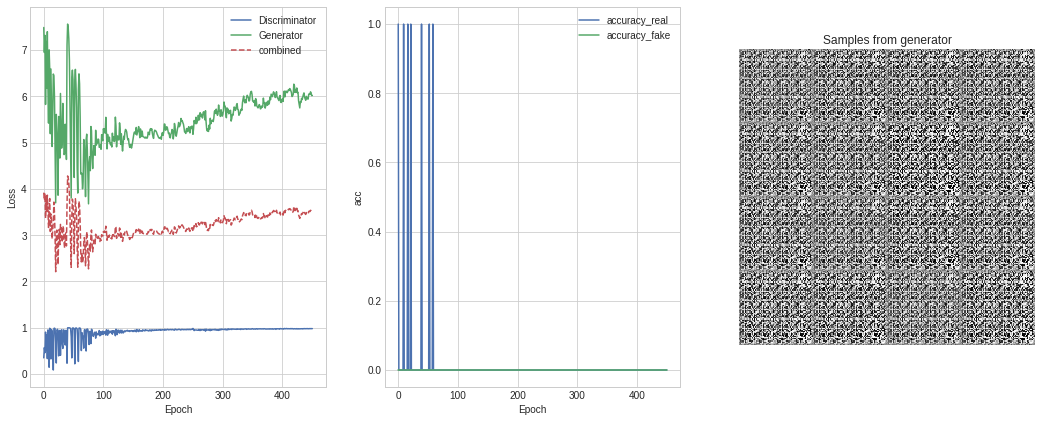

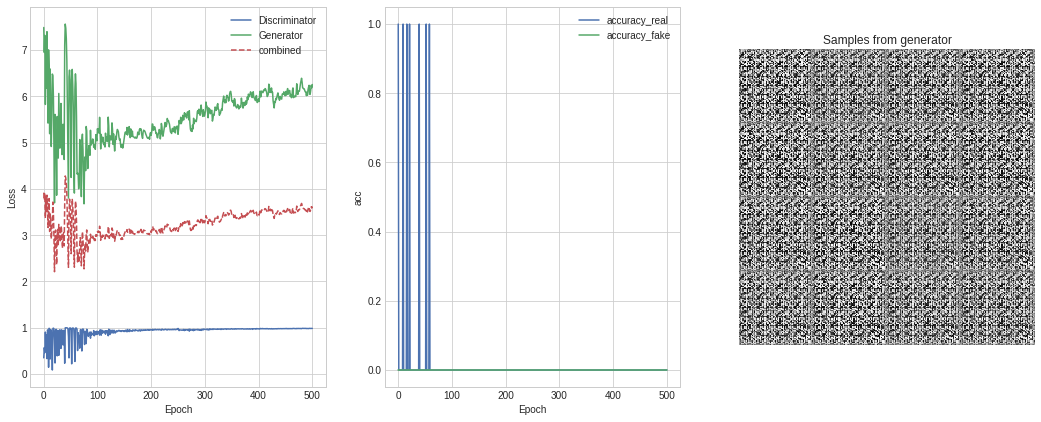

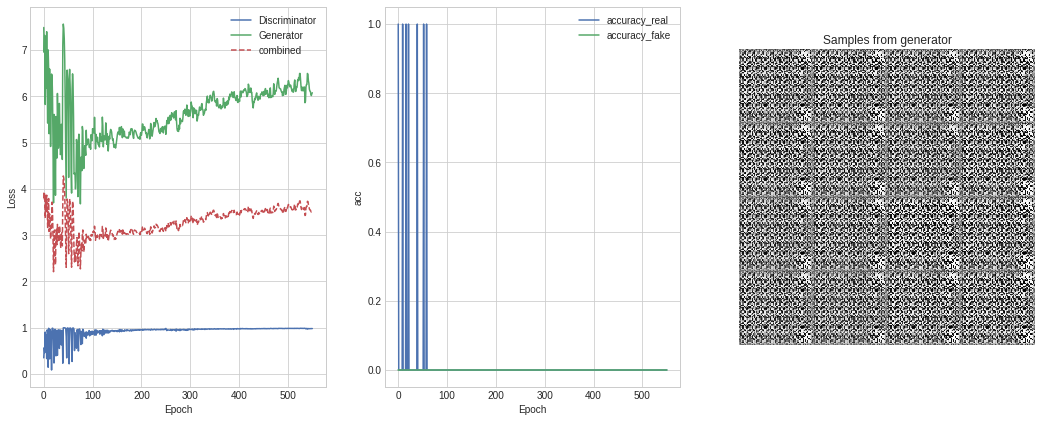

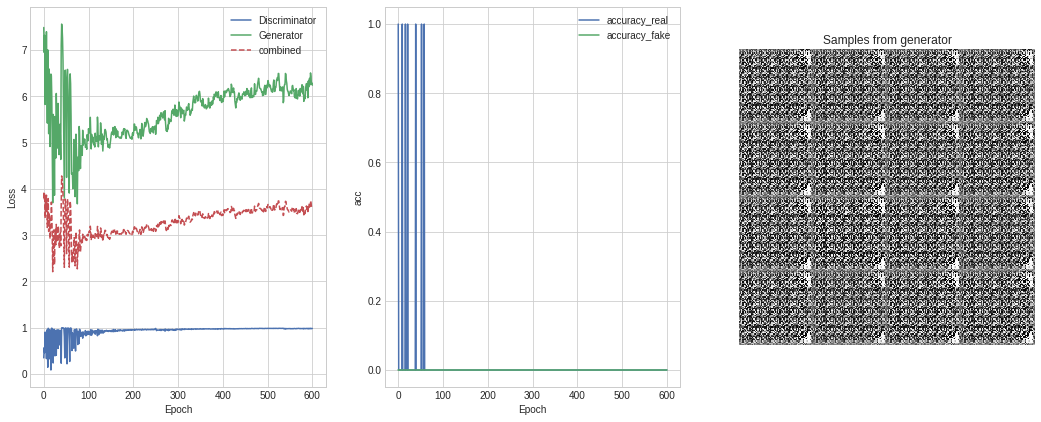

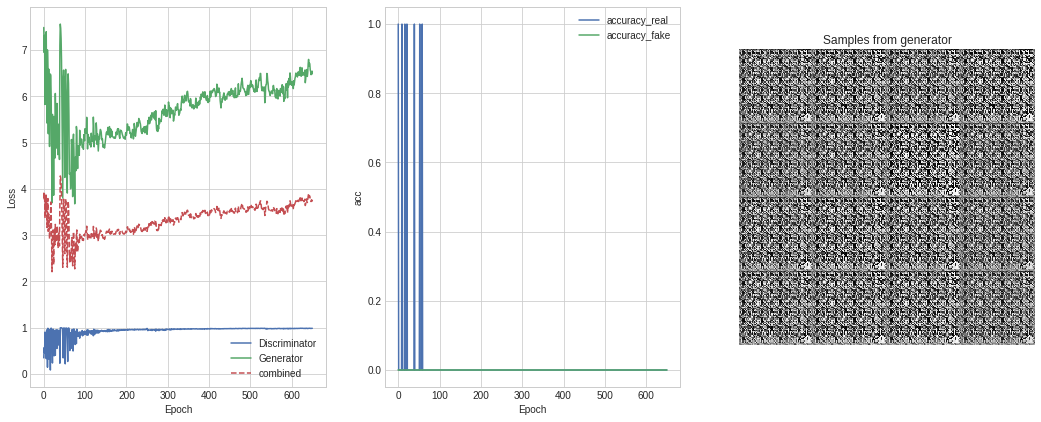

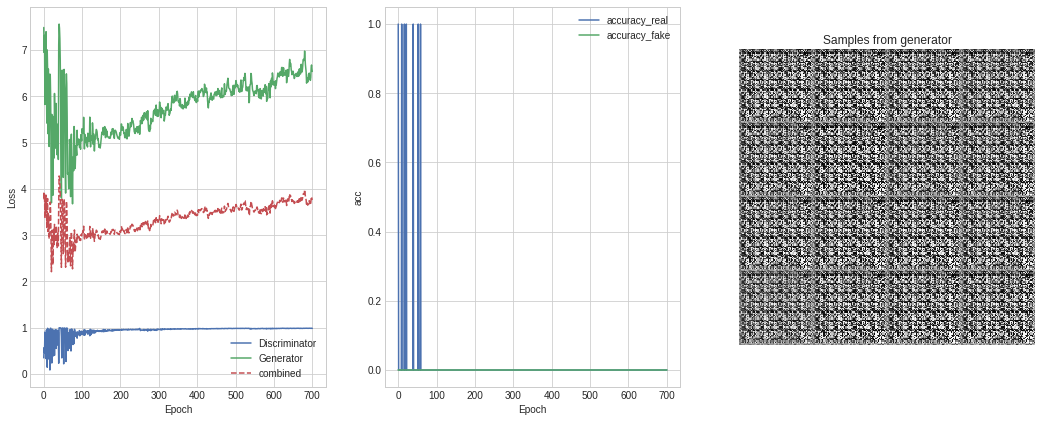

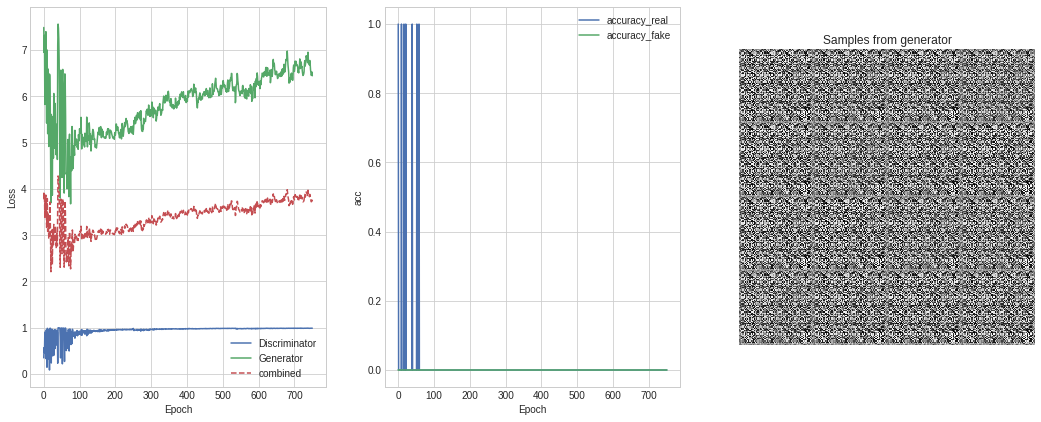

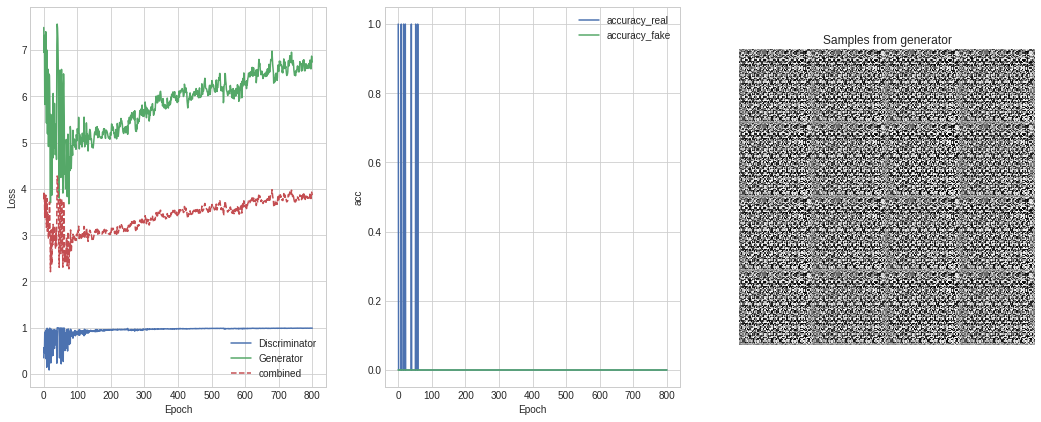

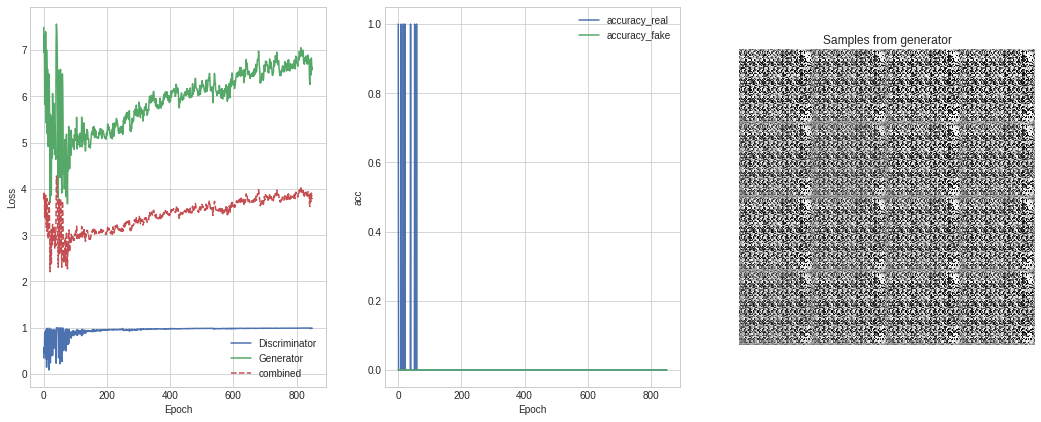

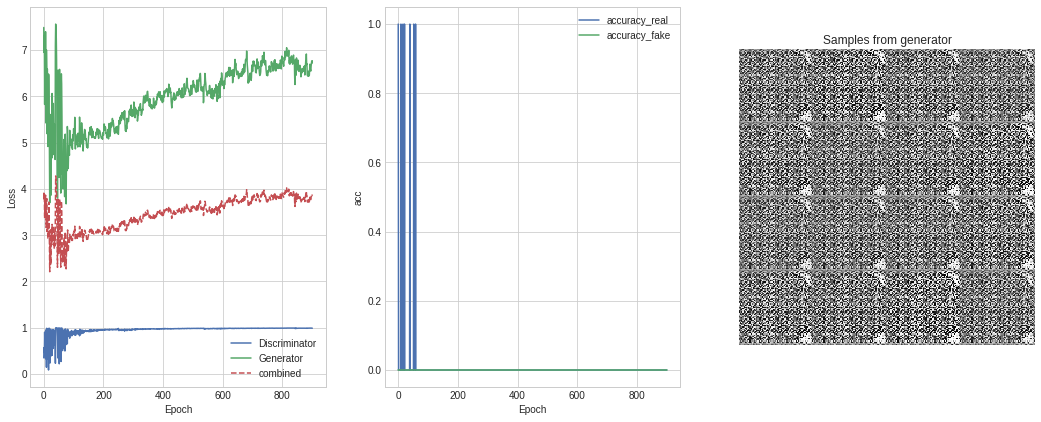

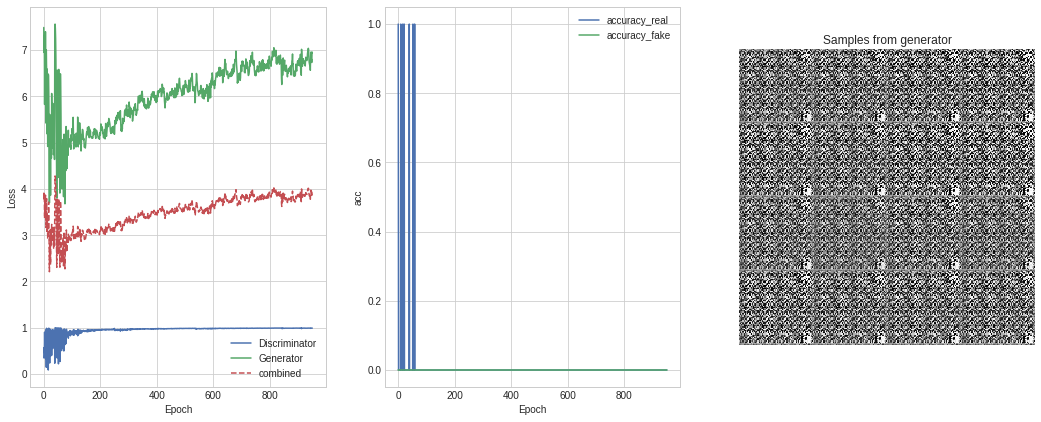

In [12]:
from torch.autograd import Variable
import os
img_name = 'GAN_stage1_settings_k'
folder = 'settings_k'
discriminator_loss, generator_loss = [], []
acc_real,acc_fake = [],[]
num_epochs = 1000
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

for epoch in range(num_epochs):
    batch_d_loss, batch_g_loss = [], []
    acc_real_avg,acc_fake_avg = [] ,[]
    for idx, (x, true_label) in enumerate(data_tr):
        batch_size = x.size(0)
        # True data is given label 1, while fake data is given label 0
        #true_label = torch.ones(batch_size, 1).to(device)
        true_label = torch.full((batch_size,1),0.9).to(device)
        true_label = true_label.to(device)
        fake_label = torch.zeros(batch_size, 1).to(device)
        
        discriminator.zero_grad()
        generator.zero_grad()
        
        # Step 1. Send real data through discriminator
        #         and backpropagate its errors.
        x_true = Variable(x).to(device) 
        output = discriminator(x_true)
        error_true = criterion(output, true_label)
        #error_true = criterion(true_label,torch.argmax(output,dim=1).long())

        error_true.backward()
        
        # Step 2. Generate fake data G(z), where z ~ N(0, 1)
        #         is a latent code.
        #z = torch.randn(batch_size, latent_dim, 1, 1)
        z = torch.randn(batch_size,latent_dim)
        z = Variable(z, requires_grad=False).to(device)
        #print(z.shape)
        x_fake = generator(z)
        #print(x_fake.shape)  
        # Step 3. Send fake data through discriminator
        #         propagate error and update D weights.
        # --------------------------------------------
        # Note: detach() is used to avoid compounding generator gradients
        output = discriminator(x_fake.detach())
        temp = list((output>0.5).cpu().numpy())
        acc_real_avg.append(sum([i[0] for i in temp])/len(temp))
        #print(int(output>0.5))
        error_fake = criterion(output, fake_label)
        #error_fake = criterion(fake_label,torch.argmax(output,dim=1).long())

        error_fake.backward()
        if idx%1==0:
          discriminator_optim.step()
        
        # Step 4. Send fake data through discriminator _again_
        #         propagate the error of the generator and
        #         update G weights.
        output = discriminator(x_fake)
        temp = list((output>0.5).cpu().numpy())
        acc_fake_avg.append(sum([i[0] for i in temp])/len(temp))
        
        error_generator = criterion(output, true_label)
        error_generator.backward()
        generator_optim.step()
        
        batch_d_loss.append((error_true/(error_true + error_fake)).item())
        batch_g_loss.append(error_generator.item())


    discriminator_loss.append(np.mean(batch_d_loss))
    generator_loss.append(np.mean(batch_g_loss))
    acc_fake.append(np.mean(acc_fake_avg))
    acc_real.append(np.mean(acc_real_avg))

    if epoch%50==0:
        plt.close('all')
        #clear_output(wait=True)

        # -- Plotting --
        f, axarr = plt.subplots(1, 3, figsize=(18, 7))

        # Loss
        ax = axarr[0]
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')

        ax.plot(np.arange(epoch+1), discriminator_loss)
        ax.plot(np.arange(epoch+1), generator_loss)
        comb = [i/2 for i in list(map(add, discriminator_loss, generator_loss) )]
        ax.plot(np.arange(epoch+1),comb, linestyle="--")
        ax.legend(['Discriminator', 'Generator','combined'])
        
        # acc
        ax = axarr[1]
        ax.set_xlabel('Epoch')
        ax.set_ylabel('acc')

        ax.plot(np.arange(epoch+1), acc_real)
        ax.plot(np.arange(epoch+1), acc_fake)

        ax.legend(['accuracy_real','accuracy_fake'])
        


        # Latent space samples
        ax = axarr[2]
        ax.set_title('Samples from generator')
        ax.axis('off')

        rows, columns = 4, 4
        
        # Generate data
        with torch.no_grad():
            #z = torch.randn(rows*columns, latent_dim, 1, 1)
            z = torch.randn(rows*columns,latent_dim)

            z = Variable(z, requires_grad=False).to(device)
            x_fake = generator(z)
        
        canvas = np.zeros((image_size*rows, columns*image_size))
        for i in range(rows):
            for j in range(columns):
                idx = i % columns + rows * j
                canvas[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size] = x_fake.data[idx].cpu()
        ax.imshow(canvas, cmap='gray')
        
        #plt.savefig('GAN/images/'+folder+'/'+img_name+'_epoch'+str(epoch)+'.png',transparent=True)
        plt.show()
        #display(Image(filename='GAN/images/'+folder+'/'+img_name+'_epoch'+str(epoch)+'.png'))

        #os.remove(tmp_img)

